# Setup

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import io
import math
import tensorflow as tf
import six
from collections import defaultdict

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Data

In [34]:
def _parse_function(example_proto):
  feature_description = {
      'img_png': tf.io.FixedLenFeature((), tf.string),      
      'label': tf.io.FixedLenFeature((), tf.float32),
      'emb': tf.io.FixedLenFeature((128,), tf.float32), # embedding from face_recognition
      'user': tf.io.FixedLenFeature((), tf.string),
  }

  data = tf.io.parse_single_example(example_proto, feature_description)
  image = data['img_png']
  image = tf.io.decode_png(image, channels=3)
  image = tf.image.resize_with_pad(image, 128, 128)
  image = tf.cast(image, tf.float32) / 255. - 0.5
  return {'image': image, 'emb': data['emb'], 'user': data['user']}, data['label']
  

# Training dataset, 32 faces per channel, random-shuffled.
ds_train = tf.data.Dataset.from_tensor_slices(['training_32faces.tfrecord'])
ds_train = ds_train.flat_map(lambda filename: tf.data.TFRecordDataset(filename))
ds_train = ds_train.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(5000).batch(32, drop_remainder=True)

# Test dataset, 1 face per channel.
ds_test = tf.data.Dataset.from_tensor_slices(['test_1face.tfrecord'])
ds_test = ds_test.flat_map(lambda filename: tf.data.TFRecordDataset(filename))
ds_test = ds_test.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32, drop_remainder=True)

# Test dataset, 32 faces per channel, used for the final ensembled predictin.
ds_test_ensemble = tf.data.Dataset.from_tensor_slices(['test_32faces.tfrecord'])
ds_test_ensemble = ds_test_ensemble.flat_map(lambda filename: tf.data.TFRecordDataset(filename))
ds_test_ensemble = ds_test_ensemble.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_ensemble = ds_test_ensemble.batch(32, drop_remainder=True)

[ 1.7917595  4.454347   4.983607  13.997833  10.510559  13.057507
  3.8286414 14.151983   5.638355  10.247112   5.049856  15.789592
 11.589896  13.815512  14.880221  13.323017  13.375456  10.755795
 15.671808  11.626263  10.1887045 15.150512   6.3969297 13.596983
 13.997833  10.845466  13.509802   7.0992017 15.123843   7.568896
 14.84513   10.471666 ]
[5.00000000e+00 8.49999847e+01 1.45000031e+02 1.20000038e+06
 3.66999922e+04 4.68599812e+05 4.50000000e+01 1.39999962e+06
 2.80000031e+02 2.81999883e+04 1.55000031e+02 7.20000000e+06
 1.08000055e+05 1.00000012e+06 2.89999925e+06 6.11099750e+05
 6.44000188e+05 4.69000078e+04 6.39999700e+06 1.11999953e+05
 2.66000117e+04 3.79999950e+06 5.99000000e+02 8.03700250e+05
 1.20000038e+06 5.13000078e+04 7.36600125e+05 1.20999988e+03
 3.69999850e+06 1.93600024e+03 2.79999900e+06 3.52999922e+04]


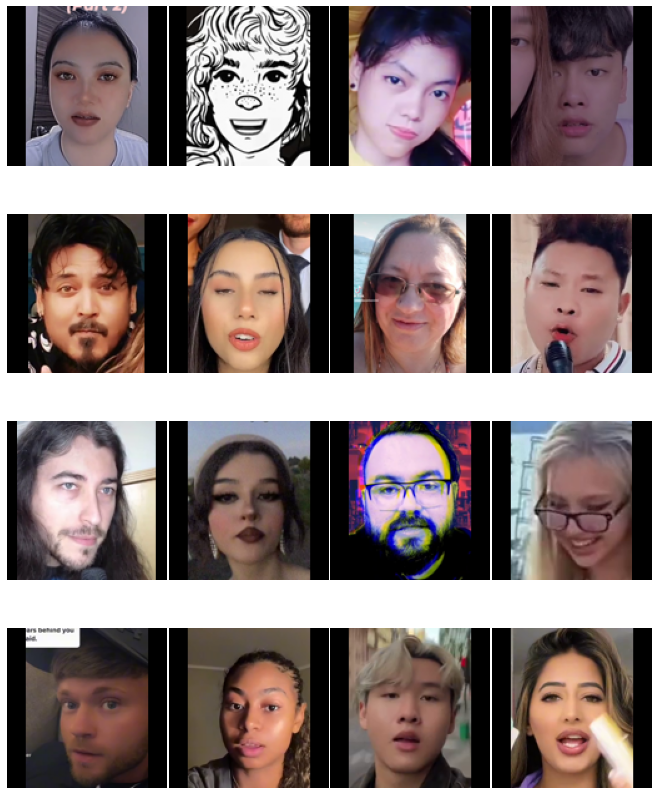

In [11]:
# Let's look at some examples.

for e in ds_test.take(1):
  pass
images, labels = e[0]['image'].numpy(), e[1].numpy()
print(labels)
print(np.exp(labels) - 1.0)
fig = plt.figure(figsize=(9, 12))
fig.tight_layout(pad=0.2)
columns = 4
rows = 4
for i, img in enumerate(images[:16]):
    fig.add_subplot(rows, columns, i + 1)
    plt.axis('off')
    plt.imshow(img + 0.5)
plt.tight_layout(pad=0.2)
plt.show()

# Training and evaluation

In [56]:
class FaceModel(tf.keras.Model):
    def __init__(self, num_layers=5, channels=128, channel_mult=[]):
        super().__init__()
        
        self.num_layers = num_layers
        self.channels = channels
        
        self.initial_block = tf.keras.models.Sequential()
        self.initial_block.add(tf.keras.layers.Conv2D(channels, (3, 3)))
        self.initial_block.add(tf.keras.layers.Activation('relu'))
        self.initial_block.add(tf.keras.layers.LayerNormalization())
        
        self.blocks = tf.keras.models.Sequential()
        for l in range(num_layers):
            mult = 1
            if channel_mult:
                mult = channel_mult[min(l, len(channel_mult) - 1)]
            block = tf.keras.models.Sequential()
            block.add(tf.keras.layers.Conv2D(channels * mult, (3, 3)))
            block.add(tf.keras.layers.Activation('relu'))
            block.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
            block.add(tf.keras.layers.LayerNormalization())
            block.add(tf.keras.layers.Dropout(0.3))
            self.blocks.add(block)
            
        self.outer = tf.keras.layers.GlobalAveragePooling2D()
        self.dnn = tf.keras.models.Sequential()
        self.dnn.add(tf.keras.layers.Dense(32))
        self.dnn.add(tf.keras.layers.Activation('relu'))
        self.dnn.add(tf.keras.layers.Dense(1))
        
        self.emb_dnn = tf.keras.models.Sequential()
        self.emb_dnn.add(tf.keras.layers.Dense(64))
        self.emb_dnn.add(tf.keras.layers.Activation('relu'))
        
    def call(self, inputs, training=False):
        flow = inputs['image']
        flow = self.initial_block(flow)
        flow = self.blocks(flow)
        flow = self.outer(flow)
        emb = self.emb_dnn(inputs['emb'])
        flow = tf.concat([flow, emb], axis=-1)
        flow = self.dnn(flow)        
        return flow

In [57]:
# Hyperparams don't affect the resulting performance that much.
model = FaceModel(num_layers=5, channels=64, channel_mult=[1, 1, 2, 2, 4])
# Our problem is regression, so we use the MSE loss.
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(3e-4))

In [ ]:
model.fit(ds_train, epochs=10, validation_data=ds_test)

In [60]:
# Simple evaluation
preds = model.predict(ds_test)[:, 0]
labels = []
users = []
for e in ds_test:
    labels.extend(e[1].numpy())
    users.extend(e[0]['user'].numpy())
labels = np.array(labels)
np.corrcoef(preds, labels)[0][1]

38/38 [==============================] - 2s 35ms/step


0.4146189444433809

In [61]:
# Ensembled evaluation

preds_num = defaultdict(float)
preds_den = defaultdict(float)
preds_all = model.predict(ds_test_ensemble)[:, 0]
users_all = []
for e in ds_test_ensemble:
    users_all.extend(e[0]['user'].numpy())
for p, u in zip(preds_all, users_all):
    u = six.ensure_str(u)
    preds_num[u] += p
    preds_den[u] += 1.0
    
preds = np.array([preds_num[six.ensure_str(u)] / preds_den[six.ensure_str(u)] for u in users])
np.corrcoef(preds, labels)[0][1]

828/828 [==============================] - 27s 33ms/step


0.44785106878224723

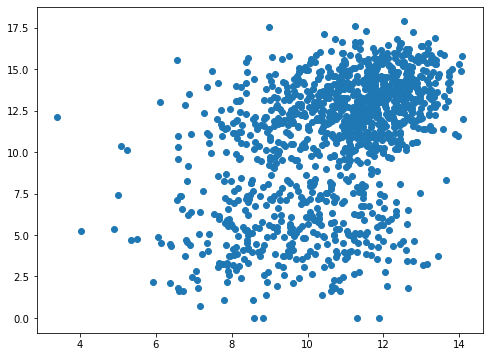

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(preds, labels)

# Results

In [64]:
pred_order = np.argsort(preds)

In [65]:
DATA_DIR = ''  #@param

def get_user(u):
    data = json.load(open(os.path.join(DATA_DIR, u, 'stats.json'), 'r'))
    s = os.path.join(DATA_DIR, u, 'faces.pkl')
    faces = pickle.load(open(s, 'rb'))
    return (data, faces)

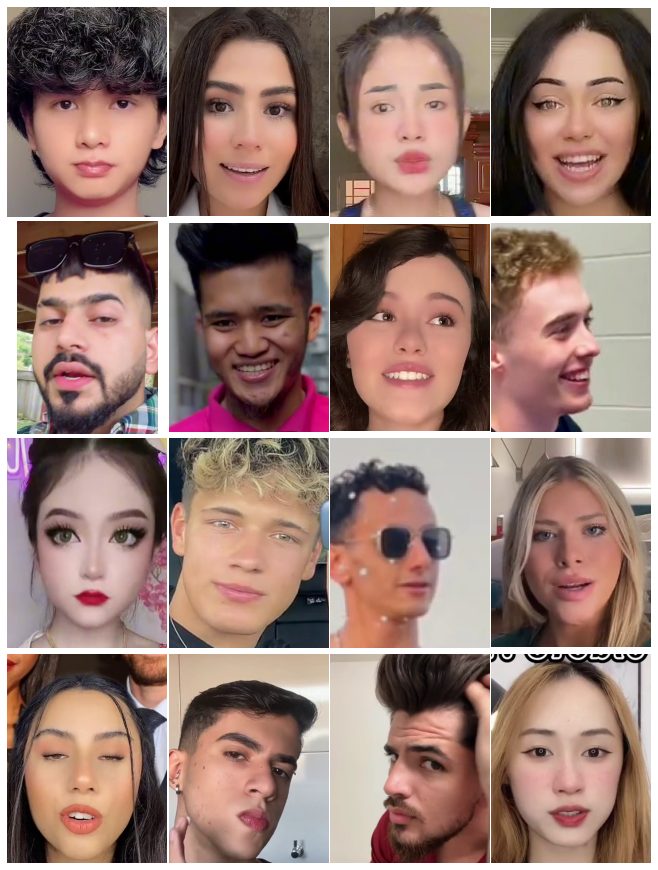

In [70]:
# Highest predictions
fig = plt.figure(figsize=(9, 12))
fig.tight_layout(pad=0.2)
columns = 4
rows = 4
for j, i in enumerate(reversed(pred_order[-16:])):
    u = six.ensure_str(users[i])
    data, faces = get_user(u)
    image = Image.open(io.BytesIO(faces[0]))
    image = np.array(image)
    fig.add_subplot(rows, columns, j + 1)
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout(pad=0.2)
plt.show()

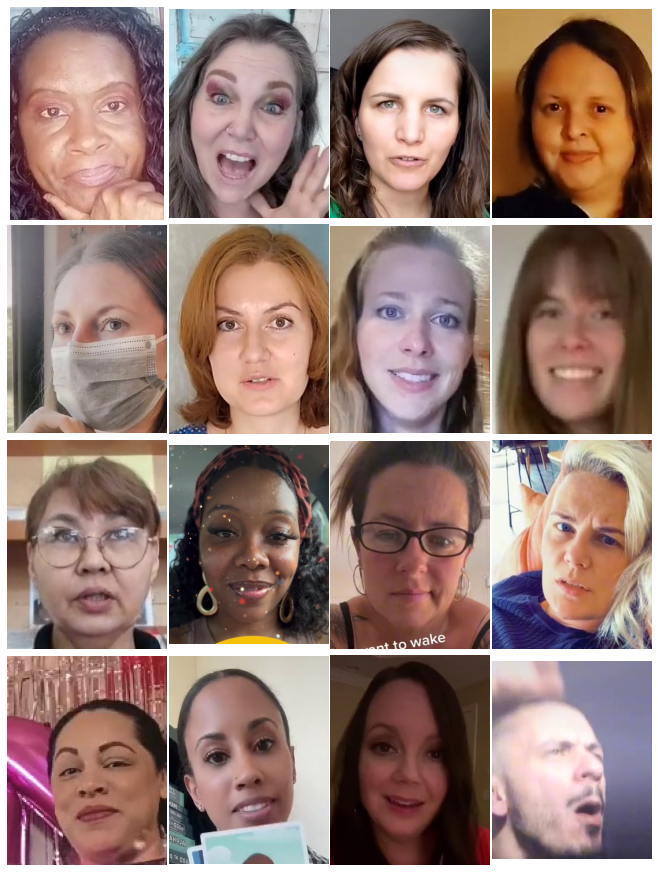

In [72]:
# Lowest predictions
fig = plt.figure(figsize=(9, 12))
fig.tight_layout(pad=0.2)
columns = 4
rows = 4
for j, i in enumerate(pred_order[:16]):
    u = six.ensure_str(users[i])
    data, faces = get_user(u)
    image = Image.open(io.BytesIO(faces[0]))
    image = np.array(image)
    fig.add_subplot(rows, columns, j + 1)
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout(pad=0.2)
plt.show()